# Semantic Segmentation of Self-driving Images with U-Net, Final Project of DL F22
## Team Members:
Shuai Zhang (sz3714), Ruichen Yang (ry2172), Juquan Yu (jy3873)
## Intro:
we implemented a deep learning model in our project to realize the effect of semantic segmentation of road condition pictures. For more descriptive information, please refer to our report.

## I. Preparation

### 1. Import Libraries

In [ ]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import albumentations as A
import torch.nn as nn
import gc

from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm
from torchsummary import summary

### 2. Download Data
This project bases on Lyft Self-driving Cars dataset, which can be found [here](https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge) on Kaggle.

To download the data, **go to Kaggle Account page** (top right), **create and download a new API token**. Then run the code block below. For uploading, select `kaggle.json` you just downloaded.

*FYI, this dataset is over 5 GB. Please allow more time for download and unzip.*

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge
!unzip lyft-udacity-challenge.zip -d data/
!rm lyft-udacity-challenge.zip
!rm kaggle.json

## II. A Quick Look on Dataset

### 1. Rearrangement of Data
This part includes defining a class for dataset, doing some transformations to dataset, and getting training/test data.

In [ ]:
img_dir = "./data/data"
data_dir = [img_dir + i + '/data' + i for i in ['A', 'B', 'C', 'D', 'E']]

In [ ]:
# combine all images and masks from dataset A, B, C, D, E
class LyftData(Dataset):  
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images = []
        self.masks = []

        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])

    def __len__(self):
        return len(self.images)

    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))

        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        
        return img, mask

In [ ]:
# define method to get train/test batches
def get_images(img_dir, transform=None, batch_size=1, shuffle=True, pin_memory=True):
    data = LyftData(img_dir, transform = transform)

    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)

    return train_batch, test_batch

In [ ]:
# define data transformation rule
transform = A.Compose([
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    A.Resize(160,240),
    ToTensorV2()
])

In [ ]:
# get train/test data
train_batch, test_batch = get_images(data_dir, transform=transform, batch_size=8)

### 2. Visualization
Now let's plot some of the images and their masks to better comprehend this dataset.

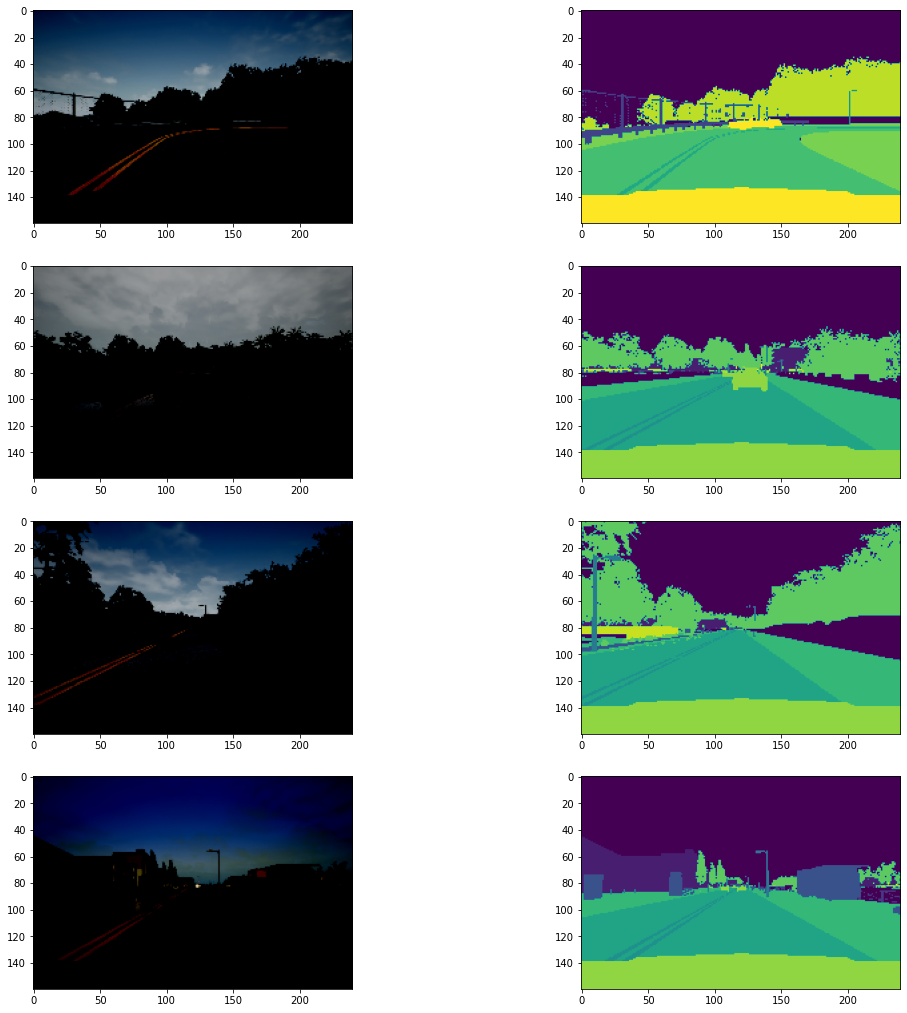

In [ ]:
# plot some images + masks
imgs, masks = next(iter(train_batch))

fig, ax = plt.subplots(4, 2, figsize=(18, 18))

for i in range(4):
  img = np.transpose(imgs[i,:,:,:],(1,2,0))
  mask = np.array(masks[i,:,:])
  ax[i][0].imshow(img)
  ax[i][1].imshow(mask)

## III. U-Net Definition
We implement our model with reference to [Pytorch-UNet](https://github.com/milesial/Pytorch-UNet).

The model was built with a classical U-Net architecture of $(64, 128, 256, 512)$ for contracting path and the reverse dimension for expanding path. We also add skip-connection in the expanding stage for better degradation.

In [ ]:
# define block on Unet path
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, downsample = None):
        super(Block, self).__init__()

        # conv1
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1), # add a learnable bias
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace=True))
        # conv2
        self.conv2 = nn.Sequential(nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, bias=False),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(inplace=True))

    def forward(self, x):
        return self.conv2(self.conv1(x))

In [ ]:
# define Unet
class Unet(nn.Module):
    def __init__(self, output_channels=23, features=[64, 128, 256, 512]):
        super(Unet,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))

        # contracting blocks
        self.block1 = Block(3, features[0])
        self.block2 = Block(features[0], features[1])
        self.block3 = Block(features[1], features[2])
        self.block4 = Block(features[2], features[3])

        self.transition_block = Block(features[3], features[3]*2) 

        # expanding blocks      
        self.block5 = Block(features[3]*2, features[3])
        self.block6 = Block(features[3], features[2])
        self.block7 = Block(features[2], features[1])
        self.block8 = Block(features[1], features[0])
  
        self.trans_block1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.trans_block2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.trans_block3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.trans_block4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2) 

        # output layer
        self.output_layer = nn.Conv2d(features[0], output_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # contract path
        x = self.block1(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.block2(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.block3(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.block4(x)
        skip_connections.append(x)
        x = self.pool(x)

        # transition
        x = self.transition_block(x)

        # expand path
        x = self.trans_block1(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.block5(x)

        x = self.trans_block2(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.block6(x)

        x = self.trans_block3(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.block7(x)

        x = self.trans_block4(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.block8(x)

        # output
        return self.output_layer(x)

In [ ]:
# set device and instantiate model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = Unet().to(DEVICE)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
             Block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

## IV. Training
We trained for 40 epochs with 1e-3 learning rate.

*FYI, each epoch takes 3+ minutes to finish, so please allow at least 2 hours to run with a GPU runtime.*

At the end the training loss should be somewhere around 0.05.

In [ ]:
# Loss and optimizer
NUM_EPOCHS = 40
LEARNING_RATE = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# Training
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1:02}/{NUM_EPOCHS}:", end=' ')
    loop = tqdm(enumerate(train_batch), total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = criterion(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
      
    torch.cuda.empty_cache()
    gc.collect()

Epoch 01/40: 

100%|██████████| 500/500 [03:21<00:00,  2.48it/s, loss=0.211]


Epoch 02/40: 

100%|██████████| 500/500 [03:15<00:00,  2.56it/s, loss=0.195]


Epoch 03/40: 

100%|██████████| 500/500 [03:18<00:00,  2.52it/s, loss=0.175]


Epoch 04/40: 

100%|██████████| 500/500 [03:16<00:00,  2.54it/s, loss=0.135]


Epoch 05/40: 

100%|██████████| 500/500 [03:16<00:00,  2.55it/s, loss=0.129]


Epoch 06/40: 

100%|██████████| 500/500 [03:15<00:00,  2.55it/s, loss=0.0982]


Epoch 07/40: 

100%|██████████| 500/500 [03:14<00:00,  2.57it/s, loss=0.107]


Epoch 08/40: 

100%|██████████| 500/500 [03:11<00:00,  2.61it/s, loss=0.106]


Epoch 09/40: 

100%|██████████| 500/500 [03:10<00:00,  2.62it/s, loss=0.0881]


Epoch 10/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0819]


Epoch 11/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0807]


Epoch 12/40: 

100%|██████████| 500/500 [03:09<00:00,  2.64it/s, loss=0.0834]


Epoch 13/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.0681]


Epoch 14/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0708]


Epoch 15/40: 

100%|██████████| 500/500 [03:08<00:00,  2.66it/s, loss=0.0789]


Epoch 16/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0652]


Epoch 17/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0715]


Epoch 18/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.101]


Epoch 19/40: 

100%|██████████| 500/500 [03:08<00:00,  2.65it/s, loss=0.0585]


Epoch 20/40: 

100%|██████████| 500/500 [03:08<00:00,  2.65it/s, loss=0.0672]


Epoch 21/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.0513]


Epoch 22/40: 

100%|██████████| 500/500 [03:06<00:00,  2.68it/s, loss=0.0585]


Epoch 23/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0588]


Epoch 24/40: 

100%|██████████| 500/500 [03:07<00:00,  2.66it/s, loss=0.0565]


Epoch 25/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.13]


Epoch 26/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.0532]


Epoch 27/40: 

100%|██████████| 500/500 [03:08<00:00,  2.65it/s, loss=0.0543]


Epoch 28/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.0587]


Epoch 29/40: 

100%|██████████| 500/500 [03:06<00:00,  2.68it/s, loss=0.0577]


Epoch 30/40: 

100%|██████████| 500/500 [03:06<00:00,  2.68it/s, loss=0.058]


Epoch 31/40: 

100%|██████████| 500/500 [03:06<00:00,  2.68it/s, loss=0.0535]


Epoch 32/40: 

100%|██████████| 500/500 [03:05<00:00,  2.69it/s, loss=0.0545]


Epoch 33/40: 

100%|██████████| 500/500 [03:05<00:00,  2.70it/s, loss=0.0643]


Epoch 34/40: 

100%|██████████| 500/500 [03:05<00:00,  2.69it/s, loss=0.07]


Epoch 35/40: 

100%|██████████| 500/500 [03:06<00:00,  2.68it/s, loss=0.0667]


Epoch 36/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.069]


Epoch 37/40: 

100%|██████████| 500/500 [03:08<00:00,  2.66it/s, loss=0.0524]


Epoch 38/40: 

100%|██████████| 500/500 [03:08<00:00,  2.66it/s, loss=0.0508]


Epoch 39/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.052]


Epoch 40/40: 

100%|██████████| 500/500 [03:07<00:00,  2.67it/s, loss=0.0542]


## V. Result
The trained model realised an accuracy that is over $95\%$ on training and test data.

### 1. Acc

In [ ]:
# define IoU for accuracy check
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    softmax = nn.Softmax(dim=1)

    with torch.no_grad():
        for img, mask in loader:
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)
            preds = torch.argmax(softmax(model(img)), axis=1)
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)

    print(f"IoU = {num_correct}/{num_pixels}, with acc {num_correct/num_pixels*100:.2f}")
    model.train()

In [ ]:
check_accuracy(test_batch, model)

IoU = 37522481/38400000, with acc 97.71


### 2. Result Visualization (Image)

Let's plot some of the predictions together with their origin image and correct masks.

The result is really convincing, with most of the datapoint correctly segmented, only some places that are diving too deep into details are not divided.

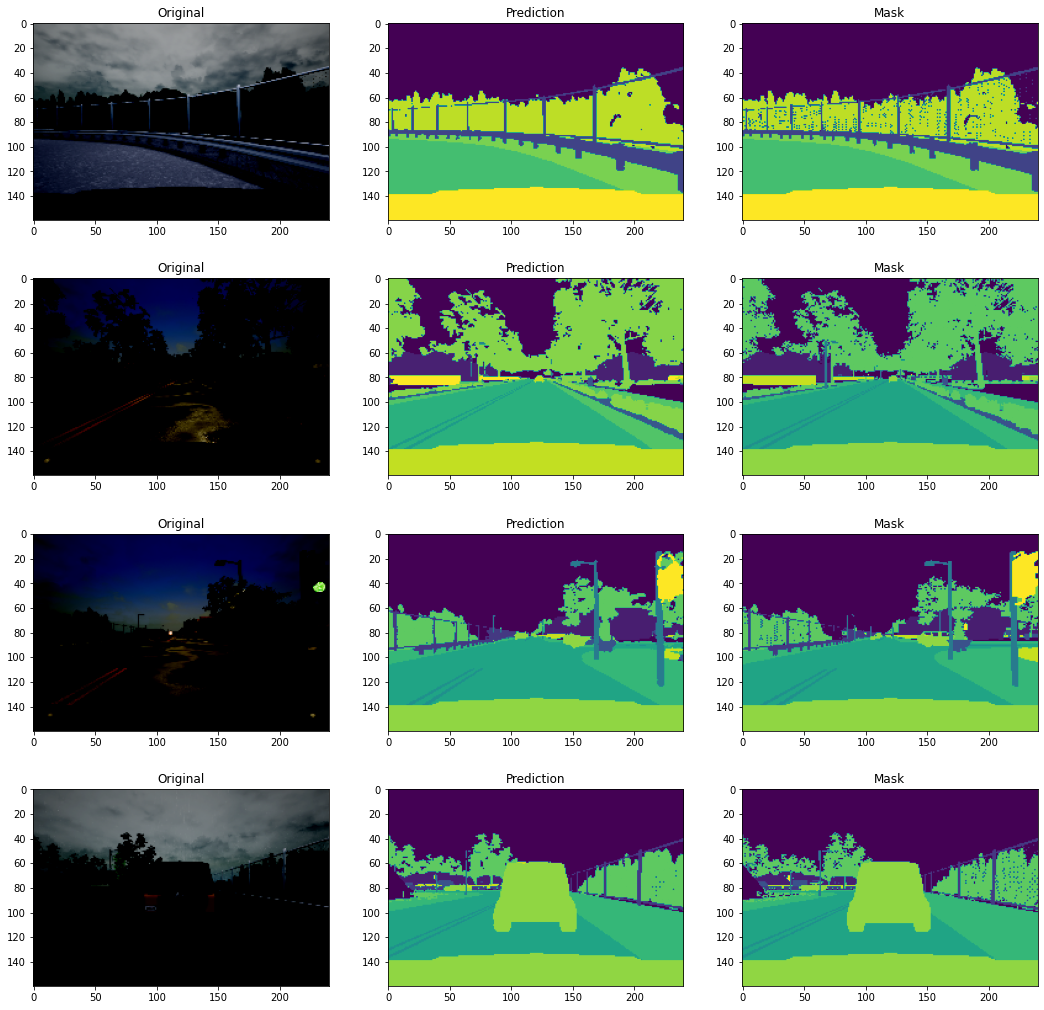

In [ ]:
# display the prediction
imgs, masks = next(iter(test_batch))
imgs = imgs.to(DEVICE)

fig, ax = plt.subplots(4, 3, figsize=(18, 18))
softmax = nn.Softmax(dim=1)
preds = torch.argmax(softmax(model(imgs)), axis=1).to('cpu')

for i in range(4):
  img = np.transpose(np.array(imgs[i,:,:,:].to('cpu')), (1,2,0))
  pred = np.array(preds[i,:,:])
  mask = np.array(masks[i,:,:])

  ax[i,0].set_title('Original')
  ax[i,1].set_title('Prediction')
  ax[i,2].set_title('Mask')

  ax[i][0].imshow(img)
  ax[i][1].imshow(pred)
  ax[i][2].imshow(mask)

### 3. Result Visualization (Metrics)

Text(0.5, 1.0, 'Loss of Train')

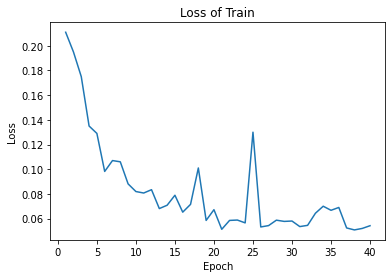

In [ ]:
import matplotlib.pyplot as plt
EPOCHS = [i for i in range(1,41)]
plt.plot(EPOCHS, a)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss of Train")